## Low-level Programming with PyTorch



In [1]:
from torch.autograd import Variable
import torch
import numpy as np
import matplotlib.pyplot as plt



from scipy.io import loadmat



%matplotlib inline  

M = loadmat("mnist_all.mat")



def get_test(M):
    batch_xs = np.zeros((0, 28*28))
    batch_y_s = np.zeros( (0, 10))
    
    test_k =  ["test"+str(i) for i in range(10)]
    for k in range(10):
        batch_xs = np.vstack((batch_xs, ((np.array(M[test_k[k]])[:])/255.)  ))
        one_hot = np.zeros(10)
        one_hot[k] = 1
        batch_y_s = np.vstack((batch_y_s,   np.tile(one_hot, (len(M[test_k[k]]), 1))   ))
    return batch_xs, batch_y_s


def get_train(M):
    batch_xs = np.zeros((0, 28*28))
    batch_y_s = np.zeros( (0, 10))
    
    train_k =  ["train"+str(i) for i in range(10)]
    for k in range(10):
        batch_xs = np.vstack((batch_xs, ((np.array(M[train_k[k]])[:])/255.)  ))
        one_hot = np.zeros(10)
        one_hot[k] = 1
        batch_y_s = np.vstack((batch_y_s,   np.tile(one_hot, (len(M[train_k[k]]), 1))   ))
    return batch_xs, batch_y_s
        

train_x, train_y = get_train(M)
test_x, test_y = get_test(M)

dim_x = 28*28
dim_h = 20
dim_out = 10

Let's display some of the training data

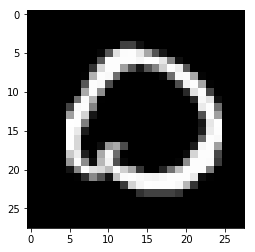

In [2]:
plt.imshow(train_x[100].reshape((28,28)), cmap = plt.cm.gray)

In [3]:
train_y[100]

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

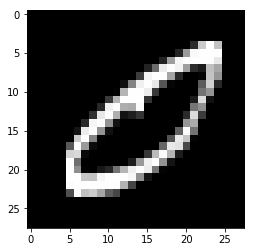

In [4]:
plt.imshow(train_x[101].reshape((28,28)), cmap = plt.cm.gray)

In [5]:
train_y[100]

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

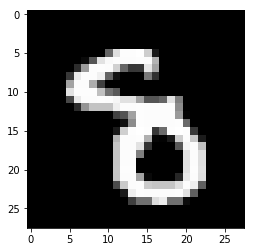

In [6]:
plt.imshow(train_x[50000].reshape((28,28)), cmap = plt.cm.gray)

In [7]:
train_y[50000]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.])

Now,  let's define `Variable`s containing the training data

In [8]:
dtype_float = torch.FloatTensor

x = Variable(torch.from_numpy(train_x), requires_grad=False).type(dtype_float)
y = Variable(torch.from_numpy(train_y.astype(float)), requires_grad=False).type(dtype_float)

In [9]:
b0 = Variable(torch.randn((1, dim_h)), requires_grad=True)
W0 = Variable(torch.randn((dim_x, dim_h)), requires_grad=True)

b1 = Variable(torch.randn((1, dim_out)), requires_grad=True)
W1 = Variable(torch.randn((dim_h, dim_out)), requires_grad=True)

Note that everything is accessible right away:

Let's now define the the model. Note that since we'll want to reuse it for different inputs, we'll want it to be in a function (or really in a class -- we'll show how to do that later). First, we'll remind ourselves of the dimensions of the data

In [10]:
x.data.shape, b0.data.shape, W0.data.shape

(torch.Size([60000, 784]), torch.Size([1, 20]), torch.Size([784, 20]))

In [11]:
b1.data.shape, W1.data.shape, y.data.shape

(torch.Size([1, 10]), torch.Size([20, 10]), torch.Size([60000, 10]))

In [12]:
def model(x, b0, W0, b1, W1):
    h = torch.nn.ReLU()(torch.matmul(x, W0) + b0.repeat(x.data.shape[0], 1))
    out = torch.matmul(h, W1) + b1.repeat(h.data.shape[0], 1)
    return out

In [13]:
y_out = model(x, b0, W0, b1, W1)

In [14]:
################################################################################
#Subsample the training set for faster training

train_idx = np.random.permutation(range(train_x.shape[0]))[:1000]
x = Variable(torch.from_numpy(train_x[train_idx]), requires_grad=False).type(dtype_float)
y = Variable(torch.from_numpy(train_y[train_idx].astype(float)), requires_grad=False).type(dtype_float)
y_out = model(x, b0, W0, b1, W1)
#################################################################################

In [15]:
logSoftMax = torch.nn.LogSoftmax() # We'll be too lazy to define this one by hand
loss = -torch.mean(torch.sum(y * logSoftMax(y_out), 1))

In [16]:
loss

Variable containing:
 48.6093
[torch.FloatTensor of size 1]

In [17]:
learning_rate = 1e-1

for t in range(1000):
    y_out = model(x, b0, W0, b1, W1)
    loss = -torch.mean(torch.sum(y * logSoftMax(y_out), 1))
    loss.backward()
    b0.data -= learning_rate * b0.grad.data
    W0.data -= learning_rate * W0.grad.data
    
    b1.data -= learning_rate * b1.grad.data
    W1.data -= learning_rate * W1.grad.data
    
    
    b0.grad.data.zero_()
    W0.grad.data.zero_()
    b1.grad.data.zero_()
    W1.grad.data.zero_()
    
    #print(loss.data.numpy())

In [18]:
x_test_all_var = Variable(torch.from_numpy(test_x), requires_grad=False).type(dtype_float)

In [19]:
y_test_out = model(x_test_all_var, b0, W0, b1, W1).data.numpy()

In [20]:
np.argmax(y_test_out, 1)

array([0, 3, 0, ..., 4, 9, 4])

In [21]:
np.argmax(y_test_out[:100], 1)

array([0, 3, 0, 0, 0, 8, 1, 0, 3, 3, 8, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0,
       0, 0, 0, 0, 9, 0, 0, 0, 3, 0, 0, 3, 0, 8, 3, 8, 0, 0, 4, 3, 5, 8, 0,
       3, 9, 2, 3, 0, 0, 1, 0, 3, 0, 0, 0, 0, 3, 0, 5, 9, 4, 0, 4, 0, 3, 3,
       0, 1, 3, 0, 0, 8, 0, 8, 0, 6, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 8, 0, 5, 0, 1, 0, 0])

In [22]:
np.argmax(test_y[:100], 1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [23]:
np.argmax(y_test_out[1000:1100], 1)

array([1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 3, 1, 1, 6, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1,
       1, 1, 1, 1, 1, 2, 1, 1])

In [24]:
np.argmax(test_y[1000:1100], 1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])